## 📌  📊 Análisis de Evasión de Clientes en TelecomX
-El presente análisis se enfoca en el comportamiento de evasión de clientes (Churn) en la empresa TelecomX.
- El objetivo principal es identificar patrones y factores asociados a la cancelación del servicio,
 mediante un análisis exploratorio de datos. Comprender este comportamiento permitirá a la empresa
tomar decisiones informadas para mejorar la retención de clientes.

## 🧹 Limpieza y Tratamiento de Datos:
 - Se importaron los datos desde una fuente JSON externa.
 - Se eliminaron registros duplicados.
 - Se estandarizaron columnas categóricas a minúsculas y se remplazaron vacíos.
 - Se convirtieron columnas numéricas a formato adecuado, manejando errores.
 - Se creó una nueva métrica: "Cuentas_Diarias" a partir del pago mensual estimado.

In [231]:
# 📦 Importar librerías
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [232]:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
respuesta = requests.get(url)

if respuesta.status_code == 200:
    datos = respuesta.json()
    df = pd.json_normalize(datos)
    print("Datos cargados correctamente:")
else:
    print(f"Error al cargar los datos: {respuesta.status_code}")


Datos cargados correctamente:


In [233]:

# 👀 Vista previa de los datos
print(df.head())
print(df.info())
print(df.columns.tolist())

   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  internet.InternetService  ... 

In [234]:
# 🧼 Eliminar duplicados
print(f"🔍 Duplicados detectados: {df.duplicated().sum()}")
df = df.drop_duplicates()

🔍 Duplicados detectados: 0


In [235]:
# 🧹 Limpiar columnas categóricas
columnas_categoricas = [
    'customer.gender', 'customer.Partner', 'customer.Dependents',
    'internet.InternetService', 'internet.TechSupport',
    'account.Contract', 'account.PaymentMethod'
]


In [236]:
# Estandarizar valores categóricos
for col in columnas_categoricas:
    print(f"\nValores únicos antes en '{col}': {df[col].unique()}")
    df[col] = df[col].astype(str).str.strip().str.lower()
    df[col] = df[col].replace('', 'desconocido')
    print(f"Valores únicos después en '{col}': {df[col].unique()}")


Valores únicos antes en 'customer.gender': ['Female' 'Male']
Valores únicos después en 'customer.gender': ['female' 'male']

Valores únicos antes en 'customer.Partner': ['Yes' 'No']
Valores únicos después en 'customer.Partner': ['yes' 'no']

Valores únicos antes en 'customer.Dependents': ['Yes' 'No']
Valores únicos después en 'customer.Dependents': ['yes' 'no']

Valores únicos antes en 'internet.InternetService': ['DSL' 'Fiber optic' 'No']
Valores únicos después en 'internet.InternetService': ['dsl' 'fiber optic' 'no']

Valores únicos antes en 'internet.TechSupport': ['Yes' 'No' 'No internet service']
Valores únicos después en 'internet.TechSupport': ['yes' 'no' 'no internet service']

Valores únicos antes en 'account.Contract': ['One year' 'Month-to-month' 'Two year']
Valores únicos después en 'account.Contract': ['one year' 'month-to-month' 'two year']

Valores únicos antes en 'account.PaymentMethod': ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (auto

In [237]:
# 🧮 Convertir variables numéricas
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')
df['account.Charges.Monthly'] = pd.to_numeric(df['account.Charges.Monthly'], errors='coerce')

In [238]:
df['Cuentas_Diarias'] = df['account.Charges.Monthly'] / 30


In [239]:
print(df.columns.tolist())


['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias']


In [240]:
assert 'Cuentas_Diarias' in df.columns


In [241]:
# 📌 Revisar valores nulos
print("\n📌 Valores nulos por columna:")
print(df.isnull().sum())



📌 Valores nulos por columna:
customerID                    0
Churn                         0
customer.gender               0
customer.SeniorCitizen        0
customer.Partner              0
customer.Dependents           0
customer.tenure               0
phone.PhoneService            0
phone.MultipleLines           0
internet.InternetService      0
internet.OnlineSecurity       0
internet.OnlineBackup         0
internet.DeviceProtection     0
internet.TechSupport          0
internet.StreamingTV          0
internet.StreamingMovies      0
account.Contract              0
account.PaperlessBilling      0
account.PaymentMethod         0
account.Charges.Monthly       0
account.Charges.Total        11
Cuentas_Diarias               0
dtype: int64


## 📊 Análisis Exploratorio de Datos
-Se realizó un análisis descriptivo con medidas como:
-**Media**, **mediana**, **desviación estándar** de variables numéricas.
-Distribución de **churn** por características como género, contrato y
método de pago. - Visualización con gráficos de cajas (boxplot) y barras
para detectar patrones en la evasión.


In [242]:
# 🧪 Verificar strings vacíos restantes
empty_strings = (df.applymap(lambda x: isinstance(x, str) and x.strip() == '')).sum()
print("\n🔍 Cantidad de strings vacíos por columna:")
print(empty_strings)


🔍 Cantidad de strings vacíos por columna:
customerID                     0
Churn                        224
customer.gender                0
customer.SeniorCitizen         0
customer.Partner               0
customer.Dependents            0
customer.tenure                0
phone.PhoneService             0
phone.MultipleLines            0
internet.InternetService       0
internet.OnlineSecurity        0
internet.OnlineBackup          0
internet.DeviceProtection      0
internet.TechSupport           0
internet.StreamingTV           0
internet.StreamingMovies       0
account.Contract               0
account.PaperlessBilling       0
account.PaymentMethod          0
account.Charges.Monthly        0
account.Charges.Total          0
Cuentas_Diarias                0
dtype: int64


/tmp/ipython-input-242-711134355.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_strings = (df.applymap(lambda x: isinstance(x, str) and x.strip() == '')).sum()


In [243]:
# ✅ Convertir columna objetivo 'Churn'
df['Churn'] = df['Churn'].astype(str).str.strip().str.lower()
df['Churn'] = df['Churn'].replace({'no': 0, 'yes': 1})

In [244]:
print("📌 Mediana de variables numéricas:")
print(df.median(numeric_only=True))


📌 Mediana de variables numéricas:
customer.SeniorCitizen        0.000000
customer.tenure              29.000000
account.Charges.Monthly      70.300000
account.Charges.Total      1391.000000
Cuentas_Diarias               2.343333
dtype: float64


## 📈 Conclusiones e Insights
1. Mayor cancelación entre clientes con contratos **mensuales**.
2. Mayor evasión entre quienes pagan con métodos **manuales** (cheques).
3. Los clientes con **bajo gasto mensual** muestran menor retención.
4. Algunas características opcionales como soporte técnico o servicios online pueden influir, pero requieren análisis adicional.

In [245]:
# 📦 Nueva columna: cargos diarios estimados
df['Cuentas_Diarias'] = df['account.Charges.Monthly'] / 30
print("\n🔢 Cargos diarios (primeros registros):")
print(df[['account.Charges.Monthly', 'Cuentas_Diarias']].head())


🔢 Cargos diarios (primeros registros):
   account.Charges.Monthly  Cuentas_Diarias
0                     65.6         2.186667
1                     59.9         1.996667
2                     73.9         2.463333
3                     98.0         3.266667
4                     83.9         2.796667


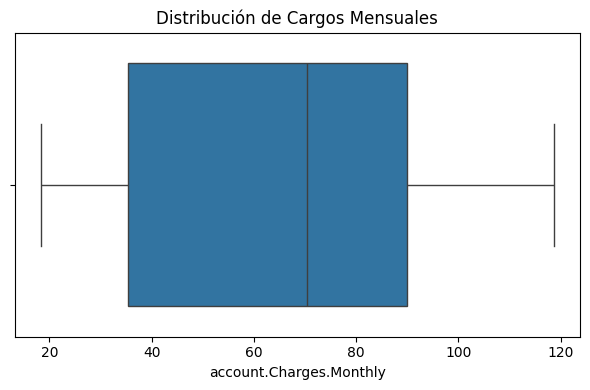

In [246]:
# 📊 Visualización: Boxplot de cargos mensuales
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='account.Charges.Monthly')
plt.title("Distribución de Cargos Mensuales")
plt.tight_layout()
plt.show()

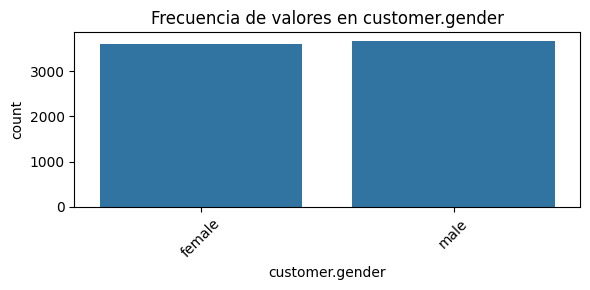

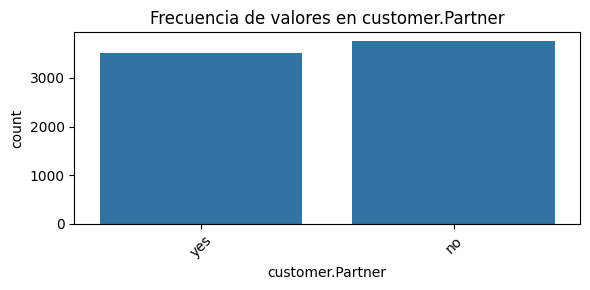

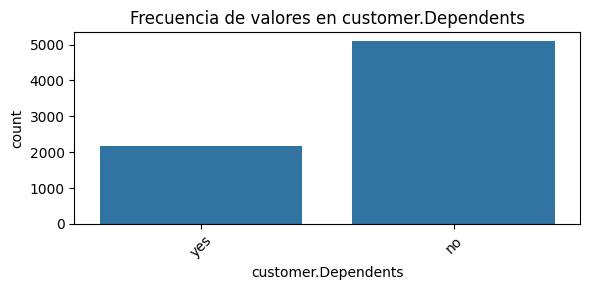

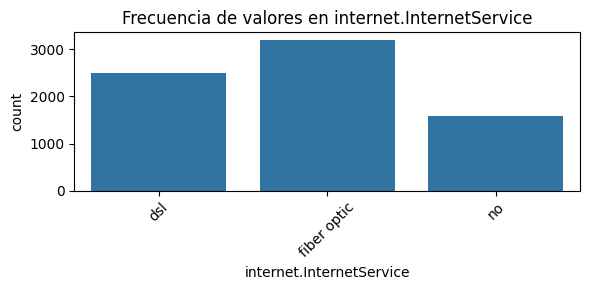

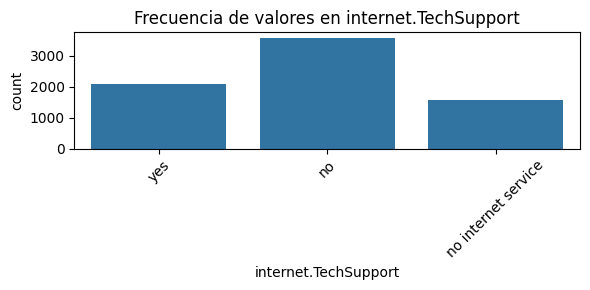

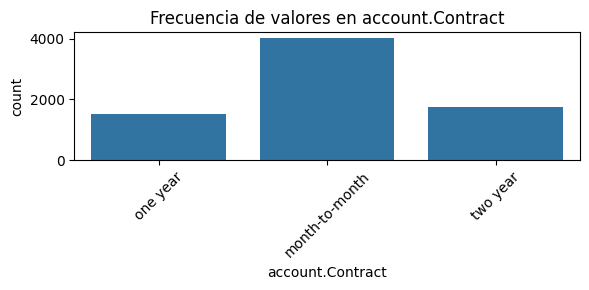

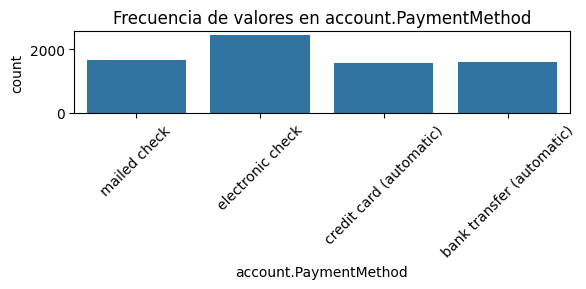

In [247]:
# 📊 Visualización: Variables categóricas
for col in columnas_categoricas:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col)
    plt.title(f'Frecuencia de valores en {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

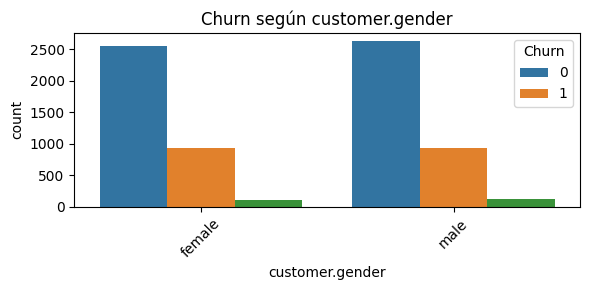

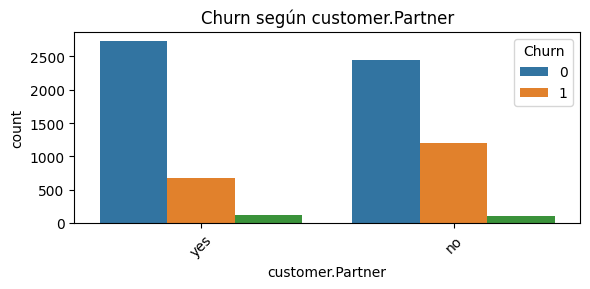

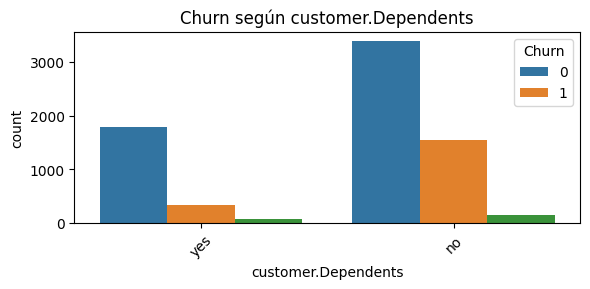

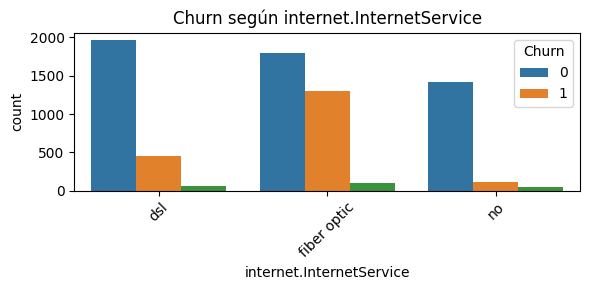

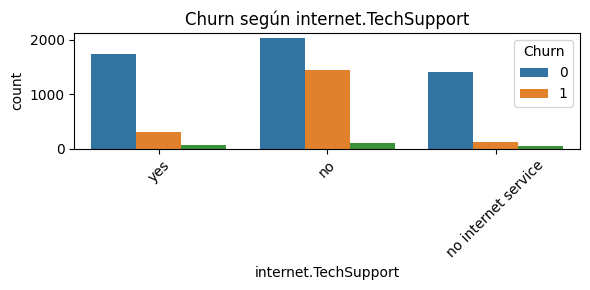

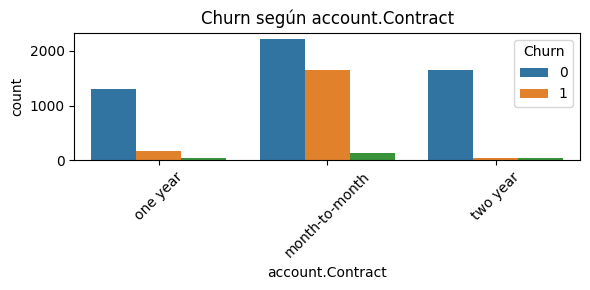

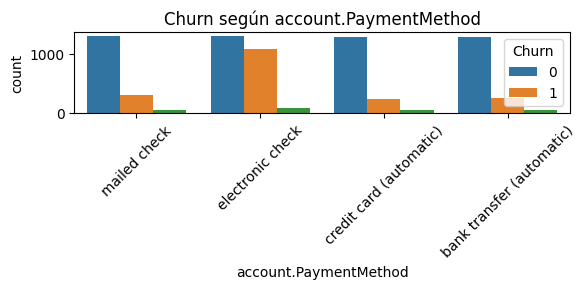

In [248]:
# 📊 Visualización: Churn vs características categóricas
for col in columnas_categoricas:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Churn según {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


📊 Promedios por grupo de churn:
       customer.SeniorCitizen  customer.tenure  account.Charges.Monthly  \
Churn                                                                     
0                    0.128721        37.569965                61.265124   
1                    0.254682        17.979133                74.441332   
                     0.178571        31.571429                63.412277   

       account.Charges.Total  Cuentas_Diarias  
Churn                                          
0                2555.344141         2.042171  
1                1531.796094         2.481378  
                 2196.933705         2.113743  


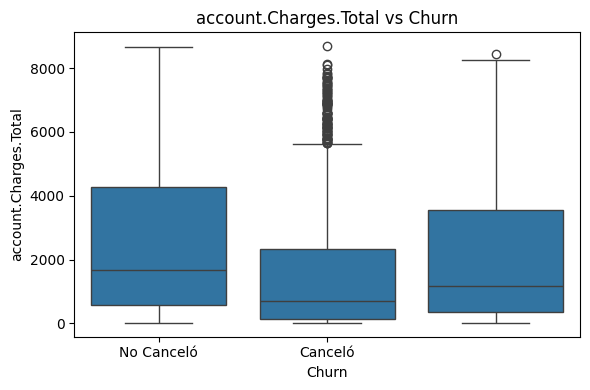

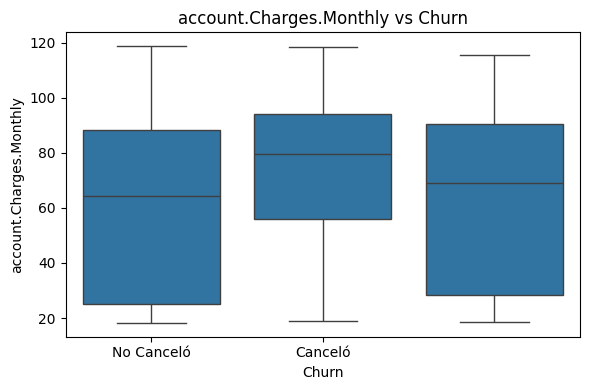

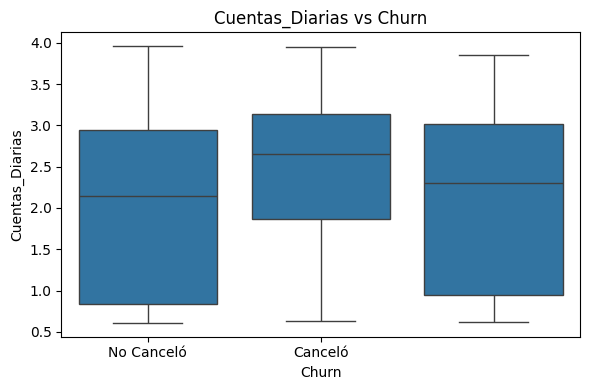

In [249]:
# 📈 Agrupación por churn
print("\n📊 Promedios por grupo de churn:")
print(df.groupby('Churn').mean(numeric_only=True))
numericas = ['account.Charges.Total', 'account.Charges.Monthly', 'Cuentas_Diarias']
for col in numericas:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Churn', y=col)
    plt.title(f'{col} vs Churn')
    plt.xticks([0, 1], ['No Canceló', 'Canceló'])
    plt.tight_layout()
    plt.show()


## ✅ Recomendaciones Estratégicas

- Incentivar contratos anuales o bianuales con promociones exclusivas.
- Fomentar el uso de pagos automáticos por su relación con mayor permanencia.
- Implementar alertas tempranas para clientes con baja permanencia o uso limitado de servicios.
- Aplicar campañas de fidelización personalizadas según perfil de cliente.

---

Este análisis permite orientar acciones enfocadas a retener clientes y reducir el churn de forma estratégica y basada en datos.

In [250]:
# ✅ Verificación final
print("\n📌 Índice del DataFrame:")
print(df.index.names)


📌 Índice del DataFrame:
[None]
